# ***Proyecto Individual 02 - Datathon - Hospitalización***
---

## Objetivo
El objetivo del proyecto es lograr predecir con de manera fiable si la estadía de un paciente que ingresa a hospitalización va a ser corta o larga. Para ello se aplican los pasos y técnicas necesarias de Machine Learning para llegar al resultado final.

## Estructura del proyecto
Para estructurar el trabajo me inspiro en la [Guía CRISP-DM de IBM](https://www.ibm.com/docs/es/SS3RA7_18.4.0/pdf/ModelerCRISPDM.pdf). Algunos pasos a seguir son:

* 1) Entendimiento del Problema y comprensión de los datos
* 2) Preparación de los datos
* 3) Modelado
* 4) Evaluación y validación
* 5) Optimización de Hiperparámetros

## Instalación e importación de librerias y paquetes necesarios

In [ ]:
#Instalación de paquetes y librerías necesarias
!pip uninstall -y pandas-profiling
!pip install pandas_profiling #--upgrade
!pip install dython
!pip install matplotlib --upgrade

In [57]:
# Trabajo con datos
import numpy as np
import pandas as pd
# opciones de visualización de pandas
#pd.options.display.max_rows = 50
pd.options.display.float_format = '{:.2f}'.format

# Análisis exploratorio de datos
from pandas_profiling import ProfileReport
from dython.nominal import associations
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

# Preprocesamiento de Datos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, OneHotEncoder, OrdinalEncoder, LabelBinarizer
from sklearn.impute import SimpleImputer

# Pipelines y Column transformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#Modelado
from time import perf_counter #Time para evaluar tiempos de procesado de modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Evaluacion y Validadción - Métricas
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Optimización de hiperparámetros
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Manejo de Warnings
import warnings
warnings.filterwarnings("ignore")

## **1) Entendimiento del problema y comprensión de los datos**

El estancia u ocupación hospitalaria es un tema de importancia a nivel mundial debido a que cuando se torna prolongada puede constituir un problema con efectos negativos en el sistema de salud, generando deficiencias en la prestación del servicio.
Se disponibilizan datos históricos de ingresos de pacientes a un Centro de Salud importante, y se conseguir un modelo que permita clasificar un nuevo paciente si va a tener una estadía corta o prolongada.  
**Se considera hospitalización corta con una duración menor o igual a 8 días**

### Dataset
---

El dataset contiene 410.000 registros y 15 dimensiones, el cual incluye la información _numérica_ de la cantidad de días

> **Descripción de las variables**
- Available Extra Rooms in Hospital: Habitaciones adicionales disponibles en el hospital. Una habitación no es igual a un paciente, pueden ser individuales o compartidas.
- Department: Área de atención a la que ingresa el paciente. 
- Ward_Facility_Code: Código de la habitación del paciente.
- doctor_name: Nombre de el/la doctor/a a cargo del paciente.
- staff_available: Cantidad de personal disponible al momento del ingreso del paciente.
- patientid: Identificador del paciente.
- Age: Edad del paciente.
- gender: Género del paciente.
- Type of Admission: Tipo de ingreso registrado según la situación de ingreso del paciente.
- Severity of Illness: Gravedad de la enfermedad/condición/estado del paciente al momento del ingreso.
- health_conditions: Condiciones de salud del paciente. 
- Visitors with Patient: Cantidad de visitantes registrados para el paciente.
- Insurance: Indica si la persona posee o no seguro de salud. 
- Admission_Deposit: Pago realizado a nombre del paciente, con el fin de cubrir los costos iniciales de internación. 
- Stay (in days): Días registrados de estancia hospitalaria. 

In [ ]:
df_raw = pd.read_csv('/content/hospitalizaciones_train.csv')

In [ ]:
df_raw.head()

Available Extra Rooms in Hospital  Department Ward_Facility_Code  \
0                                  4  gynecology                  D   
1                                  4  gynecology                  B   
2                                  2  gynecology                  B   
3                                  4  gynecology                  D   
4                                  2  anesthesia                  E   

  doctor_name  staff_available  patientid    Age  gender Type of Admission  \
0   Dr Sophia                0      33070  41-50  Female            Trauma   
1   Dr Sophia                2      34808  31-40  Female            Trauma   
2   Dr Sophia                8      44577  21-30  Female            Trauma   
3   Dr Olivia                7       3695  31-40  Female            Urgent   
4     Dr Mark               10     108956  71-80    Male            Trauma   

  Severity of Illness health_conditions  Visitors with Patient Insurance  \
0             Extreme          Diabetes                      4       Yes   
1               Minor     Heart disease                      2        No   
2             Extreme          Diabetes                      2       Yes   
3            Moderate              None                      4        No   
4            Moderate          Diabetes                      2        No   

   Admission_Deposit  Stay (in days)  
0            2966.41               8  
1            3554.84               9  
2            5624.73               7  
3            4814.15               8  
4            5169.27              34

In [ ]:
df_raw.shape

(410000, 15)

* **Estandarización de columnas**  
Separaciones con guión bajo y palabras en minúsculas

In [ ]:
#Hago una copia del dataset original y renombro columna target
df = df_raw.copy()
df.rename({'Stay (in days)':'stay_days'}, axis = 1, inplace = True)
#Renombre de columnas - strip(): elimina espacios al inicio y al final
df.rename(lambda x : x.lower().strip().replace(' ','_'), axis = 1, inplace = True)

* **Agrego columna de Stay como categórica**  
Se considera que por encima de 8 días la estadía del paciente es larga, mientras que por debajo de ese valor se considera corta. Se asigna 0 y 1 para estadías corta y larga respectivamente.
* **Dropeo columna `patientid`**  
No se considera necesaria para el análisis

In [ ]:
df['stay'] = df['stay_days'].apply(lambda x: 0 if x <=8 else 1)
df.drop(columns=['patientid'],inplace=True)

In [ ]:
df.head(5)

available_extra_rooms_in_hospital  department ward_facility_code  \
0                                  4  gynecology                  D   
1                                  4  gynecology                  B   
2                                  2  gynecology                  B   
3                                  4  gynecology                  D   
4                                  2  anesthesia                  E   

  doctor_name  staff_available    age  gender type_of_admission  \
0   Dr Sophia                0  41-50  Female            Trauma   
1   Dr Sophia                2  31-40  Female            Trauma   
2   Dr Sophia                8  21-30  Female            Trauma   
3   Dr Olivia                7  31-40  Female            Urgent   
4     Dr Mark               10  71-80    Male            Trauma   

  severity_of_illness health_conditions  visitors_with_patient insurance  \
0             Extreme          Diabetes                      4       Yes   
1               Minor     Heart disease                      2        No   
2             Extreme          Diabetes                      2       Yes   
3            Moderate              None                      4        No   
4            Moderate          Diabetes                      2        No   

   admission_deposit  stay_days  stay  
0            2966.41          8     0  
1            3554.84          9     1  
2            5624.73          7     0  
3            4814.15          8     0  
4            5169.27         34     1

### EDA - Exploratory Data Analysis  
---
Se realiza el analisis exploratorio utilizando una librería llamada [**Pandas Profiling**](https://pandas-profiling.ydata.ai/docs/master/index.html) que ortorga un reporte HTML más visual e interactivo para poder explorar los datos y sacar algunas conclusiones.  
También se obtienen listas de las variables numericas y categóricas para luego facilitar los análisis

In [ ]:
#Obtenemos listas de variables categóricas y numéricas, excluyendo la variable target (Stay)
cols = df.drop(columns=['stay_days','stay']).columns
num_cols = df.drop(columns=['stay_days','stay'])._get_numeric_data().columns.tolist()
cat_cols = list(set(cols)-set(num_cols))
print(f'Lista columnas numericas:\t{num_cols}')
print(f'Lista columnas categóricas:\t{cat_cols}')

Lista columnas numericas:	['available_extra_rooms_in_hospital', 'staff_available', 'visitors_with_patient', 'admission_deposit']
Lista columnas categóricas:	['health_conditions', 'doctor_name', 'gender', 'age', 'insurance', 'severity_of_illness', 'ward_facility_code', 'department', 'type_of_admission']


#### Reporte usando ProfileReport

Utilizo ProfileReport para obtener realizar un análisis detallado e interactivo de los datos en forma general y específica, otorgando información de cada una de las variables, su interacción y correlación, valores faltantes, duplicados y estadísticas. En las observaciones al final del EDA se sacan algunas conclusiones.

In [ ]:
report = ProfileReport(df)

In [ ]:
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Análisis variables cuantitativas


* **Se utiliza un `Pairplot` para el análisis de las variables cuantitativas**.
Se utiliza el parámetro _hue_ para separar las observaciones por estadía (stay) larga y corta para ver si se encuentra algún patrón u observación importante
* En el plot no se observan correlaciones con algún tipo de tendencia entre las variables
* Es interesante observar las gráficas de distribución de la diagonal, en las cuales se observa que en ninguna variable hay una separación por estadía, más bien, se encuentran superpuestas. Por ello, diría que ninguna de estas variables sería un clasificador determinante en el modelo aunque luego en el apartado de Feature Selection se realizan otros análisis.

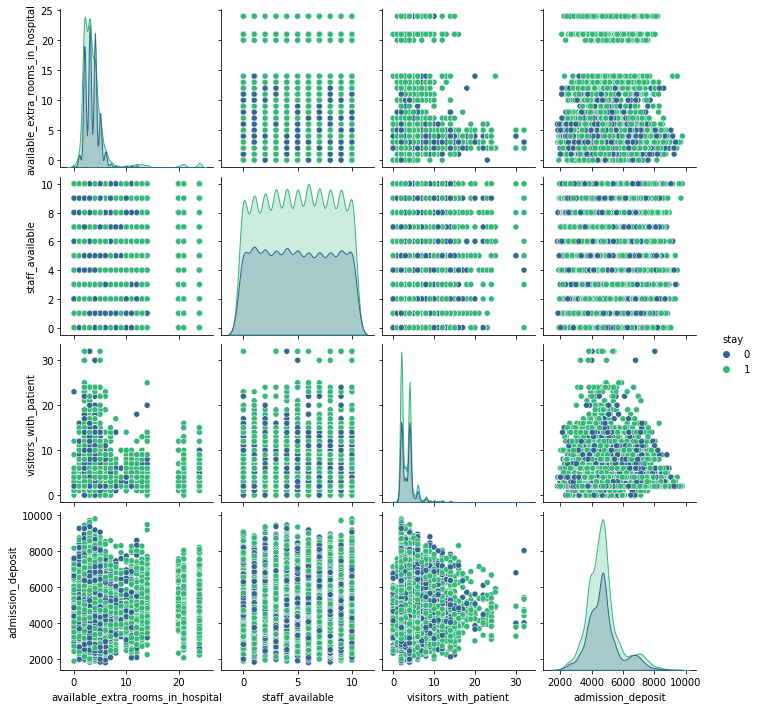

In [ ]:
#Pairplot para variables cuantitativas. con un hue en stay y sample del 10% datos
sns.pairplot(df.drop(columns=['stay_days']).sample(frac=0.1), hue="stay", palette = 'viridis')
plt.show()

* **Se hace uso de `Boxplots` para analizar la distribución de las variables y la detección de outliers**. Se observa que solo la variable _staff_available_ no presenta valores atípicos
* Realizo un dataframe de outliers `df_outliers` para analizar que porcentaje representa en cada variable para luego analizar su remosión. Se observa que la variable que más presenta valores atípicos es _admission_deposit_ con un 8,3%

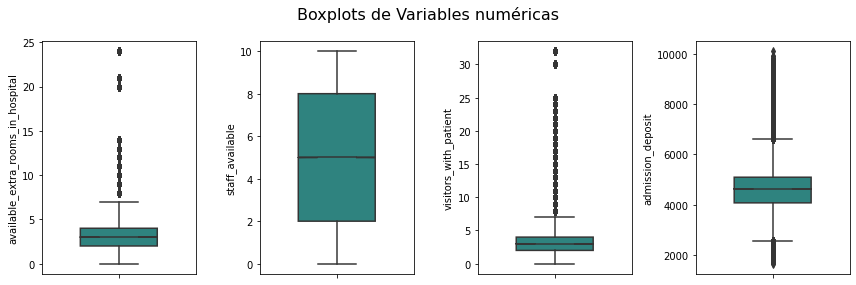

In [ ]:
#Boxplots de variables numericas
fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (12,4))
for i in range(0,4):
  sns.boxplot(data = df, y = num_cols[i], notch = True, showfliers = True, width = 0.5 ,  palette = 'viridis', ax = ax[i])
fig.suptitle('Boxplots de Variables numéricas', fontsize=16,fontweight=200)
plt.tight_layout()
plt.show()

In [ ]:
#Calculo de outliers y porcentaje
outliers_dicc = {'Mediana': [], 'Q1': [], 'Q3':[], 'Limite Inferior': [], 'Limite Superior': [], 'Cantidad Outliers':[], '% Outliers':[] }
for i, col in enumerate(num_cols):
  M = df[col].median()
  Q1 = df[col].quantile(q=.25)
  Q3 = df[col].quantile(q=.75)
  IQR = Q3 - Q1
  LI = Q1 - 1.5*IQR
  LS = Q3 + 1.5*IQR
  outliers = df[(df[col]<LI) | (df[col]>LS)].shape[0]
  outliers_perc = outliers/df.shape[0]*100
  #Append de los valores en diccionario
  outliers_dicc['Mediana'].append(M)
  outliers_dicc['Q1'].append(Q1)
  outliers_dicc['Q3'].append(Q3)
  outliers_dicc['Limite Inferior'].append(LI)
  outliers_dicc['Limite Superior'].append(LS)
  outliers_dicc['Cantidad Outliers'].append(outliers)
  outliers_dicc['% Outliers'].append(outliers_perc)
df_outliers = pd.DataFrame(outliers_dicc, index=num_cols)

In [ ]:
df_outliers

Mediana      Q1      Q3  Limite Inferior  \
available_extra_rooms_in_hospital     3.00    2.00    4.00            -1.00   
staff_available                       5.00    2.00    8.00            -7.00   
visitors_with_patient                 3.00    2.00    4.00            -1.00   
admission_deposit                  4627.49 4072.64 5092.35          2543.07   

                                   Limite Superior  Cantidad Outliers  \
available_extra_rooms_in_hospital             7.00              14603   
staff_available                              17.00                  0   
visitors_with_patient                         7.00              20163   
admission_deposit                          6621.92              34234   

                                   % Outliers  
available_extra_rooms_in_hospital        3.56  
staff_available                          0.00  
visitors_with_patient                    4.92  
admission_deposit                        8.35

#### Análisis variables cualitativas



* **Se utilizan `Barplots` graficados en forma múltiple para cada variable y separado por la variable _stay_**  
* Algunas observaciones interesantes son:
  * Las variables _age_ y _department_ podrian ser buenos clasificadores, ya que hay una separación marcada en cuando a la distribución de la variable target _stay_ dentro de las categorías de cada variable. Por ejemplo, rangos de edad de 11 a 50 años solo cuentan con estadías cortas, el resto de los rangos cuentan con hospitalización de larga duración

  * Hay categorías de variables que casi no tienen datos, por ejemplo surgery en _department_ o el rango etario de 91-100 años en _age_. Una vez aplicado el encoding en estas variables, su varianza debería tender a cero, por lo que no sería util para el modelo. **Se plantea luego aplicar VarianceThreshold de sklearn en un Pipeline para eliminar dichas variables como un paso extra**


In [ ]:
# Matriz de 3x3 de variables categóricas para poder graficar
cat_cols_matrix = np.array(cat_cols).reshape(3,3)

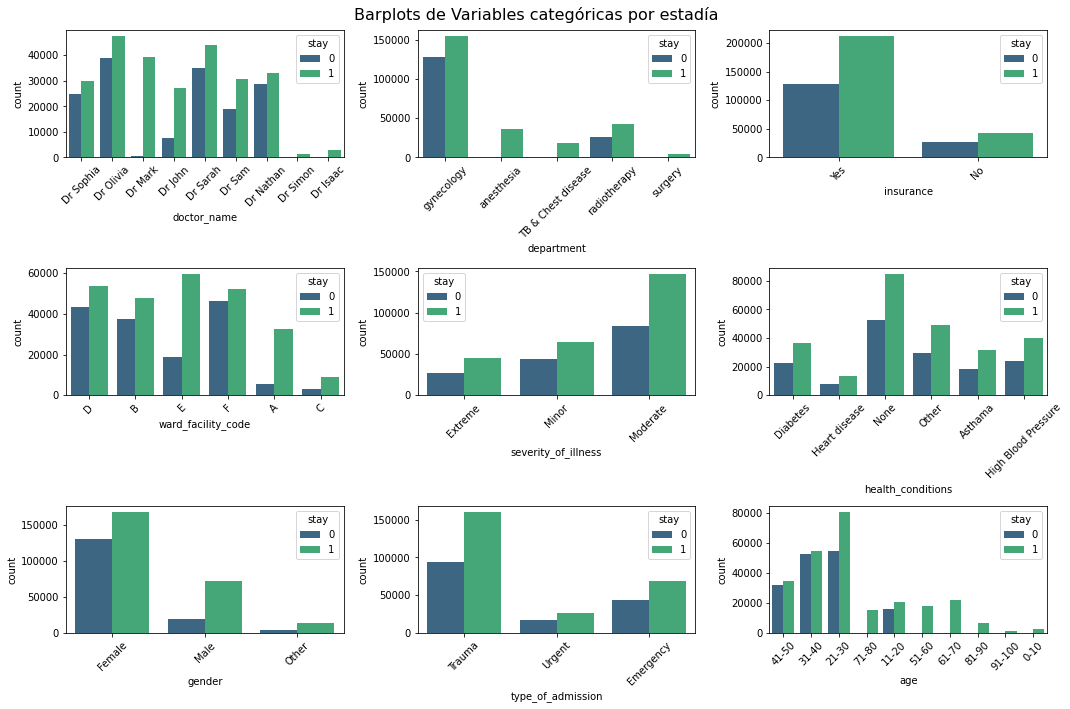

In [ ]:
#Ploteo de variables categóticas
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (15,10))
for i in range(0,3):
  for j in range(0,3):
    sns.countplot(data=df, x=cat_cols_matrix[i,j], hue="stay", ax=ax[i,j], palette = 'viridis')
    plt.setp(ax[i,j].get_xticklabels(), rotation=45, ha='center')
fig.suptitle('Barplots de Variables categóricas por estadía', fontsize=16,fontweight=200)
plt.tight_layout()
plt.show()

### **Observaciones y conclusiones EDA**
---
Se sacan algunas conclusiones generales y por variables

* **Valores faltantes y duplicados**: El dataset no cuenta con nulos ni duplicados 

* **Correlación entre variables**: El reporte de `PandasProfiling` entrega una sección de Correlación en base al tipo de variable (numérica, categórica o ambas) considerando algunos coeficientes como Pearson, CramerV, Spearman's, entre otras.  
De acuerdo a la correlación 'Auto' se ve que:
  - _stay_ está levemente correlacionada con las variables _department_, _age_, _gender_, _doctor_name_, _ward_facility_code_
  - A su vez, estas ultimas 4 features se encuentran correlacionadas entre sí por lo que se analiza en la sección de feature selection con cual quedarse

* **Variable target**: La variable dependiente a predecir por el modelo de clasificación es `stay`. No se trata de un dataset desbalanceado, ya que cuenta con un 60% y 40% de datos para las categorías de 1(larga) y 0 (corta)

* **Variables cuantitativas**: Cuenta con 4 variables numéricas (excluyendo la variable a predecir _stay_days_) con las siguientes características. Curtosis alta significa que los datos están concentrados cerca de la mediana, mientras que una curva de distribución con curtosis baja significa una curva mas aplanada con los datos mas distribuidos

Con respecto a los outliers, su ocurrencia no se debe a errores sino que son mas bien propios de cada registro por lo que no se deberían eliminar. En caso de considerar cierta variable se puede aplicar `RobustScaler` para el escalado

|              Variable             |       Distribución      |     Sesgo    | Curtosis | Outliers |
|:---------------------------------:|:-----------------------:|:------------:|:--------:|:--------:|
| available_extra_rooms_in_hospital |  Aproximadamente normal | A la derecha |   Alta   |    Si    |
| staff_available                   |         Uniforme        |       -      |  Pequeña |    No    |
| visitors_with_patient             |         Bimodal         | A la derecha |   Alta   |    Si    |
| admission_deposit                 | Aproximandamente normal | A la derecha |   Alta   |    Si    |

* **Variables categóricas**:

Cuenta con 9 variables categóricas sin incluir la variable a predecir _stay_.

Hay 3 variables ordinales, que al momento de aplicar el encoding se aplicará en el orden en que aparece en la columna Categorías (ya ordenado). El resto de las variables son nominales

Las categorías con pocos datos podrian significar categorías con varianza cercana a cero que puede afectar al modelo. Aunque se verá luego si se aplica un `VarianceThreshold`

|       Variable      | Tipo de variable categórica | Dicotómica o multicategórica | Cantidad de categorías |                                                     Categorías                                                    |    Categorías con pocos datos    |
|:-------------------:|:---------------------------:|:----------------------------:|:----------------------:|:-----------------------------------------------------------------------------------------------------------------:|:--------------------------------:|
| department          |           Nominal           |        Multicategórica       |            4           |                  'gynecology',   'radiotherapy',  'anesthesia',  'TB & Chest disease',  'surgery'                 | 'surgery',  'TB & Chest disease' |
| age                 |           Ordinal           |        Multicategórica       |           10           |         '0-10',  '11-20',  '21-30',  '31-40',  '41-50',  '51-60',  '61-70',  '71-80',  '81-90',  '91-100'         |    '0-10',  '91-100',  '81-90'   |
| gender              |           Nominal           |        Multicategórica       |            3           |                                            'Female',  'Male',  'Other'                                            |              'Other'             |
| severity_of_illness |           Ordinal           |        Multicategórica       |            3           |                                          'Minor',  'Moderate',  'Extreme'                                         |                 -                |
| ward_facility_code  |           Nominal           |        Multicategórica       |            6           |                                         'F',  'D',  'B',  'E',  'A',  'C'                                         |                 -                |
| health_conditions   |           Nominal           |        Multicategórica       |            6           |                'None',  'Other',  'High Blood Pressure',  'Diabetes',  'Asthama',  'Heart disease'                |                 -                |
| insurance           |           Nominal           |          Dicotómica          |            2           |                                                    'Yes',  'No'                                                   |                 -                |
| doctor_name         |           Nominal           |        Multicategórica       |            9           | 'Dr Olivia',  'Dr Sarah',  'Dr Nathan',  'Dr Sophia',  'Dr Sam',  'Dr Mark',  'Dr John',  'Dr Isaac',  'Dr Simon' |      'Dr Simon',  'Dr Isaac'     |
| type_of_admission   |           Ordinal           |        Multicategórica       |            3           |                                         'Trauma',  'Emergency',  'Urgent'                                         |                 -                |

## **2) Preparación de los datos**

### Feature Selection
---
Se toma como referencia [A Practical Guide to Dimensionality Reduction](https://storage.googleapis.com/kaggle-forum-message-attachments/469411/11253/dimreductiontechniquespydatadcoct2016-170626164019.pdf) de [PyData 2016](https://pydata.org/about/) (un programa educacional a nivel mundial de data) para realizar la selección de variables (Dimensionality Reduction)  
Los pasos y criterios seguidos son:
- Porcentaje de valores nulos: No hay variables con valores nulos, por lo que no se realizan reducción de campos de acuerdo a este criterio
- Variables con varianza cero: No hay variables con varianza nula o casi nula (mismos valores en todos los registros), por lo que no se dropean campos
- Correlación con el target y multicolinearidad
- Selección Tree-based Method (Feature importance)
- Criterio propio en base al problema

#### Correlación con el target y multicolinearidad
Utilizo los coeficientes de correlación para ver que features estarían asociadas con el target, y las features relacionadas entre sí.  
Las observaciones resultantes son idénticas a las del EDA:
  - _stay_ está levemente correlacionada con las variables _department_, _age_, _gender_, _doctor_name_, _ward_facility_code_ y a su vez estas features están correlacionadas entre sí
  - Para evitar redundancia de información (multicolinearidad) se elige la variable **_department_** por sobre _doctor_name_ y _ward_facility_code_. Las variables _age_ y _gender_, a pesar de que estén correlacionadas con department, son relativas al paciente y no al Centro de salud en si, por lo que también se considerarán para el análisis


* **Libreria `Dython` para analisis de correlacion de variables**  
Utilizo [Dython](https://github.com/shakedzy/dython) para hacer la correlación de variables tanto numericas como categóricas basado en los siguientes coeficientes:

     * `Pearson's R` para correlación de variables continua-continua
     * `Correlation Ratio` para correlación de variables categorica-continua
     * `Cramer's V` para correlación de variables categorica-categorica (basado en Chi-Cuadrado)


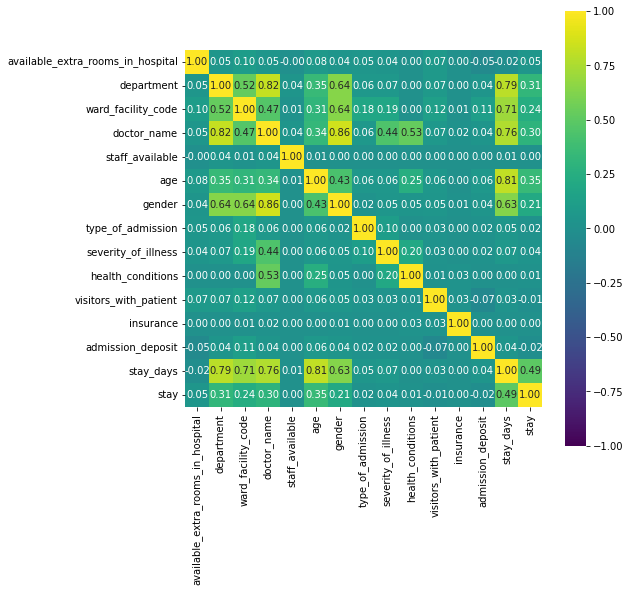

{'corr':                                    available_extra_rooms_in_hospital  \
 available_extra_rooms_in_hospital                               1.00   
 department                                                      0.05   
 ward_facility_code                                              0.10   
 doctor_name                                                     0.05   
 staff_available                                                -0.00   
 age                                                             0.08   
 gender                                                          0.04   
 type_of_admission                                               0.05   
 severity_of_illness                                             0.04   
 health_conditions                                               0.00   
 visitors_with_patient                                           0.07   
 insurance                                                       0.00   
 admission_deposit                         

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
associations(df, cmap="viridis",ax=ax)
#fig.savefig('Categorical Corr Heat Map. png')

#### Tree-based Methon (Feature importance)
Se utiliza RandomForest para obtener la importancia de las variables a la hora de realizar las predicciones.

**Observaciones**
  - Se obtiene df_importances luego de entrenar el modelo de RandomForest con variables codificadas. De acuerdo a las `feature_mportances_` del modelo las variables con preponderancia para la predicción y que se tendrán en cuenta son: _admission_deposit_ y_staff_available_

In [ ]:
#División del Dataframe
X_num = df[num_cols]
X_cat = pd.get_dummies(df[cat_cols], columns = cat_cols, drop_first=True)
X = pd.concat([X_num,X_cat], axis=1)
y = df[['stay']]

In [ ]:
X.head()

available_extra_rooms_in_hospital  staff_available  visitors_with_patient  \
0                                  4                0                      4   
1                                  4                2                      2   
2                                  2                8                      2   
3                                  4                7                      4   
4                                  2               10                      2   

   admission_deposit  doctor_name_Dr John  doctor_name_Dr Mark  \
0            2966.41                    0                    0   
1            3554.84                    0                    0   
2            5624.73                    0                    0   
3            4814.15                    0                    0   
4            5169.27                    0                    1   

   doctor_name_Dr Nathan  doctor_name_Dr Olivia  doctor_name_Dr Sam  \
0                      0                      0                   0   
1                      0                      0                   0   
2                      0                      0                   0   
3                      0                      1                   0   
4                      0                      0                   0   

   doctor_name_Dr Sarah  ...  type_of_admission_Urgent  age_11-20  age_21-30  \
0                     0  ...                         0          0          0   
1                     0  ...                         0          0          0   
2                     0  ...                         0          0          1   
3                     0  ...                         1          0          0   
4                     0  ...                         0          0          0   

   age_31-40  age_41-50  age_51-60  age_61-70  age_71-80  age_81-90  \
0          0          1          0          0          0          0   
1          1          0          0          0          0          0   
2          0          0          0          0          0          0   
3          1          0          0          0          0          0   
4          0          0          0          0          1          0   

   age_91-100  
0           0  
1           0  
2           0  
3           0  
4           0  

[5 rows x 42 columns]

In [ ]:
#Feature importance
clf = RandomForestClassifier(n_estimators=50)
rf_feature_selection = clf.fit(X, y)
importances = rf_feature_selection.feature_importances_ 
df_feature_importances = pd.DataFrame(importances, index = X.columns, columns = ['Importancia']).sort_values('Importancia',ascending=False)

In [ ]:
df_feature_importances

Importancia
admission_deposit                             0.39
staff_available                               0.11
available_extra_rooms_in_hospital             0.09
visitors_with_patient                         0.06
age_31-40                                     0.05
age_41-50                                     0.04
department_radiotherapy                       0.03
department_anesthesia                         0.03
doctor_name_Dr Mark                           0.02
department_gynecology                         0.02
age_61-70                                     0.02
age_21-30                                     0.01
insurance_Yes                                 0.01
type_of_admission_Trauma                      0.01
age_71-80                                     0.01
age_51-60                                     0.01
doctor_name_Dr Sam                            0.01
gender_Male                                   0.01
type_of_admission_Urgent                      0.01
age_81-90                                     0.01
severity_of_illness_Minor                     0.01
severity_of_illness_Moderate                  0.00
health_conditions_High Blood Pressure         0.00
ward_facility_code_F                          0.00
ward_facility_code_E                          0.00
ward_facility_code_D                          0.00
ward_facility_code_B                          0.00
doctor_name_Dr John                           0.00
health_conditions_None                        0.00
health_conditions_Other                       0.00
department_surgery                            0.00
health_conditions_Diabetes                    0.00
doctor_name_Dr Sarah                          0.00
doctor_name_Dr Olivia                         0.00
age_11-20                                     0.00
health_conditions_Heart disease               0.00
doctor_name_Dr Nathan                         0.00
doctor_name_Dr Sophia                         0.00
gender_Other                                  0.00
ward_facility_code_C                          0.00
age_91-100                                    0.00
doctor_name_Dr Simon                          0.00

#### Selección en base a criterio propio
De acuerdo al problema planteado considero a algunas variables importantes relativas al paciente que ingresa a ser hospitalizado y que se van a tomar en cuenta en el problema. Estas variables están relacionadas con la edad, el género y situación de salud del paciente (afecciones anteriores, tipo de admisión y seguro de salud)


### Variables Seleccionadas
---
Por los criterios mencionados en los puntos anteriores son: 
- **Cuantitativas:**  
  - _staff_available_
  - _admission_deposit_
- **Cualitativas Dicotómica:**
  - _insurance_
- **Cualitativas Multicategóricas Ordinales:**
  - _age_
  - _severity_of_ilness_
  - _type_of_admission_

- **Cualitativas Multicategóricas Nominales:**
  - _department_
  - _gender_
  - _health_conditions_

In [ ]:
num_cols

['available_extra_rooms_in_hospital',
 'staff_available',
 'visitors_with_patient',
 'admission_deposit']

In [ ]:
cat_cols

['doctor_name',
 'department',
 'insurance',
 'ward_facility_code',
 'severity_of_illness',
 'health_conditions',
 'gender',
 'type_of_admission',
 'age']

In [33]:
# Variables
num_features = ['staff_available', 'admission_deposit']
dic_features = ['insurance']
ord_features = ['age','severity_of_illness','type_of_admission']
nom_features = ['department','gender','health_conditions']
total_features = num_features + dic_features + ord_features + nom_features

# Orden de Variables Ordinales para aplicar OrdinalEncoder: Es importante la posición en la que aparecen las variables
orden = [
    ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100'],
    ['Minor', 'Moderate', 'Extreme'],
    ['Trauma', 'Emergency', 'Urgent']
    ]

In [ ]:
total_features

['staff_available',
 'admission_deposit',
 'insurance',
 'age',
 'severity_of_illness',
 'type_of_admission',
 'department',
 'gender',
 'health_conditions']

### División del Dataset en Train-Test Split
---

In [ ]:
# Defino X e y
X = df[total_features]
y = df[['stay']]

In [ ]:
X.head()

staff_available  admission_deposit insurance    age severity_of_illness  \
0                0            2966.41       Yes  41-50             Extreme   
1                2            3554.84        No  31-40               Minor   
2                8            5624.73       Yes  21-30             Extreme   
3                7            4814.15        No  31-40            Moderate   
4               10            5169.27        No  71-80            Moderate   

  type_of_admission  department  gender health_conditions  
0            Trauma  gynecology  Female          Diabetes  
1            Trauma  gynecology  Female     Heart disease  
2            Trauma  gynecology  Female          Diabetes  
3            Urgent  gynecology  Female              None  
4            Trauma  anesthesia    Male          Diabetes

In [ ]:
y.head()

stay
0     0
1     1
2     0
3     0
4     1

In [ ]:
# Reparto de datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [ ]:
# Verificación
print(f'X_train shape: {X_train.shape}\nX_test shape: {X_test.shape}\ny_train shape: {X_train.shape}\ny_test shape: {X_test.shape}\n')

X_train shape: (328000, 9)
X_test shape: (82000, 9)
y_train shape: (328000, 9)
y_test shape: (82000, 9)



### Preprocesamiento de datos
---
Para facilitar el preprocesado de datos se utilizan pipelines por cada etapa. En cada pipeline se coloca un SimpleImputer para imputar valores faltantes en caso de que lleguen datos nuevos con nulos. Las variables numéricas se imputan por la mediana, y las categóricas por la moda. Técnicas de preprocesado

* StandardScaler
* RobustScaler
* LabelBinarizer
* OrdinalEncoder
* OneHotEncoder


In [ ]:
# Pipeline StandardScaler: para variables sin outliers
Pipe_StandardScaler = Pipeline(steps=[
                        ("Imputador mediana", SimpleImputer(strategy='median')),
                        ("StandardScaler", StandardScaler())
                        ])

In [ ]:
# Pipeline RobustScaler: para variables con outliers
Pipe_RobustScaler = Pipeline(steps=[
                        ("Imputador mediana", SimpleImputer(strategy='median')),
                        ("StandardScaler", RobustScaler())
                        ])

In [ ]:
# Pipeline OneHotEncoding
Pipe_OneHotEncoder = Pipeline(steps=[
                        #("Imputador moda", SimpleImputer(strategy='most_frequent')),
                        ("OneHotEncoder", OneHotEncoder(drop='first', handle_unknown='ignore'))
                        ])

In [ ]:
# Pipeline OrdinalEncoder
Pipe_OrdinalEncoder = Pipeline(steps=[
                        ("Imputador moda", SimpleImputer(strategy='most_frequent')),
                        ("OrdinalEncoder", OrdinalEncoder(categories=orden))
                        ])

In [ ]:
# Debido a que LabelBinarizer no acepta mas de dos argumentos por lo que se hace una modificación
class LabelBinarizerPipeline(LabelBinarizer):
    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
        super(LabelBinarizerPipeline, self).fit(X)
    def transform(self, X, y=None):
        return super(LabelBinarizerPipeline, self).transform(X)

    def fit_transform(self, X, y=None):
        return super(LabelBinarizerPipeline, self).fit(X).transform(X)

In [ ]:
# Pipeline LabelBinarizer
Pipe_LabelBinarizer = Pipeline(steps=[
                        ("Imputador moda", SimpleImputer(strategy='most_frequent')),
                        ("LabelBinarizer", LabelBinarizerPipeline())
                        ])

In [ ]:
# Preprocesador de columnas
Preprocesador = ColumnTransformer( 
                        transformers = [
                            ('Escalado Estandar', Pipe_StandardScaler, ['staff_available']),
                            ('Escalado Robusto',Pipe_RobustScaler,['admission_deposit']),
                            ('Encoding Label', Pipe_LabelBinarizer, dic_features),
                            ('Encoding Ordinal', Pipe_OrdinalEncoder, ord_features),
                            ('Encoding OneHot', Pipe_OneHotEncoder, nom_features)
                            ],
                        remainder='drop', n_jobs=-1)

In [ ]:
# Preprocesado de Features en train y test
X_train_procesado = Preprocesador.fit_transform(X_train)
X_test_procesado = Preprocesador.transform(X_test)

* Armado del Dataframe con sus respectivas columnas para corroborar el preprocesado

In [ ]:
# Obtención de las columnas
encoded_cat = Preprocesador.named_transformers_['Encoding OneHot'].named_steps['OneHotEncoder'].get_feature_names_out()
labels = np.concatenate([num_features,dic_features,ord_features, encoded_cat])

In [ ]:
labels

array(['staff_available', 'admission_deposit', 'insurance', 'age',
       'severity_of_illness', 'type_of_admission',
       'department_anesthesia', 'department_gynecology',
       'department_radiotherapy', 'department_surgery', 'gender_Male',
       'gender_Other', 'health_conditions_Diabetes',
       'health_conditions_Heart disease',
       'health_conditions_High Blood Pressure', 'health_conditions_None',
       'health_conditions_Other'], dtype=object)

In [ ]:
# Dataframe transformado
df_X_train_procesado = pd.DataFrame(X_train_procesado, columns=labels, index = X_train.index)
df_X_train_procesado.head(10)

staff_available  admission_deposit  insurance  age  \
113232            -0.32               2.92       1.00 3.00   
329178            -0.64               0.25       1.00 6.00   
248342             0.63               0.92       1.00 6.00   
209872            -0.01               0.41       1.00 3.00   
194305            -1.59               0.23       1.00 1.00   
87560              0.94              -0.03       1.00 6.00   
339324            -0.64               1.76       0.00 6.00   
41030              1.58               0.28       1.00 2.00   
254337            -1.59               0.11       1.00 7.00   
197941             1.58               0.33       1.00 3.00   

        severity_of_illness  type_of_admission  department_anesthesia  \
113232                 1.00               0.00                   0.00   
329178                 1.00               0.00                   0.00   
248342                 2.00               0.00                   1.00   
209872                 1.00               0.00                   0.00   
194305                 0.00               0.00                   0.00   
87560                  1.00               0.00                   1.00   
339324                 2.00               0.00                   0.00   
41030                  2.00               1.00                   0.00   
254337                 1.00               0.00                   0.00   
197941                 1.00               0.00                   0.00   

        department_gynecology  department_radiotherapy  department_surgery  \
113232                   1.00                     0.00                0.00   
329178                   0.00                     0.00                0.00   
248342                   0.00                     0.00                0.00   
209872                   1.00                     0.00                0.00   
194305                   1.00                     0.00                0.00   
87560                    0.00                     0.00                0.00   
339324                   0.00                     1.00                0.00   
41030                    0.00                     1.00                0.00   
254337                   0.00                     1.00                0.00   
197941                   1.00                     0.00                0.00   

        gender_Male  gender_Other  health_conditions_Diabetes  \
113232         0.00          0.00                        0.00   
329178         1.00          0.00                        0.00   
248342         0.00          1.00                        1.00   
209872         0.00          0.00                        0.00   
194305         0.00          0.00                        0.00   
87560          0.00          1.00                        0.00   
339324         1.00          0.00                        1.00   
41030          1.00          0.00                        0.00   
254337         1.00          0.00                        0.00   
197941         0.00          0.00                        0.00   

        health_conditions_Heart disease  \
113232                             0.00   
329178                             0.00   
248342                             0.00   
209872                             0.00   
194305                             0.00   
87560                              0.00   
339324                             0.00   
41030                              0.00   
254337                             0.00   
197941                             0.00   

        health_conditions_High Blood Pressure  health_conditions_None  \
113232                                   0.00                    1.00   
329178                                   0.00                    0.00   
248342                                   0.00                    0.00   
209872                                   0.00                    1.00   
194305                                   1.00                    0.00   
87560                             

In [ ]:
X_train.head(10)

staff_available  admission_deposit insurance    age  \
113232                4            7605.41       Yes  31-40   
329178                3            4882.78       Yes  61-70   
248342                7            5568.29       Yes  61-70   
209872                5            5045.60       Yes  31-40   
194305                0            4861.32       Yes  11-20   
87560                 8            4601.12       Yes  61-70   
339324                3            6421.30        No  61-70   
41030                10            4916.04       Yes  21-30   
254337                0            4738.69       Yes  71-80   
197941               10            4968.24       Yes  31-40   

       severity_of_illness type_of_admission          department  gender  \
113232            Moderate            Trauma          gynecology  Female   
329178            Moderate            Trauma  TB & Chest disease    Male   
248342             Extreme            Trauma          anesthesia   Other   
209872            Moderate            Trauma          gynecology  Female   
194305               Minor            Trauma          gynecology  Female   
87560             Moderate            Trauma          anesthesia   Other   
339324             Extreme            Trauma        radiotherapy    Male   
41030              Extreme         Emergency        radiotherapy    Male   
254337            Moderate            Trauma        radiotherapy    Male   
197941            Moderate            Trauma          gynecology  Female   

          health_conditions  
113232                 None  
329178                Other  
248342             Diabetes  
209872                 None  
194305  High Blood Pressure  
87560               Asthama  
339324             Diabetes  
41030                  None  
254337  High Blood Pressure  
197941                Other

In [ ]:
X_train_procesado.shape

(328000, 17)

In [ ]:
X_test_procesado.shape

(82000, 17)

In [ ]:
y_train.shape

(328000, 1)

In [ ]:
y_test.shape

(82000, 1)

#### Imputación de valores faltantes

#### Escalado de Variables numéricas

Encoder Variables categóricas 

## 3) **Modelado** 

* Se decide realizar un diccionario instanciando varios modelos de clasificación con los parámetros por defecto para luego evaluar las métricas 

In [ ]:
#Objeto de Modelos de clasificación:
#Se defina como un objeto (o diccionario) donde el key es el nombre de cada modelo y el valor la función correspondiente a dicho modelo
dict_classifiers = {
    "Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "LogisticReg": LogisticRegression(),
    "SVM": LinearSVC(),
    "RandomForest": RandomForestClassifier()
}

In [ ]:
dict_classifiers.items()

dict_items([('Tree', DecisionTreeClassifier()), ('KNN', KNeighborsClassifier()), ('LogisticReg', LogisticRegression()), ('SVM', LinearSVC()), ('RandomForest', RandomForestClassifier())])

In [ ]:
len(dict_classifiers)

5

In [ ]:
# Se define una función para obtener un resumen de los datos de entrenamiento y testeo
no_classifiers = len(dict_classifiers.keys())

def batch_classify(X_train, y_train, X_test, y_test):
    columnas = ['Modelo', 'Training Time', 'Accuracy (Train)', 'Accuracy (Test)', 'Recall']
    df_results = pd.DataFrame(data=np.zeros(shape=(no_classifiers,len(columnas))), columns = columnas)
    count = 0
    for key, classifier in dict_classifiers.items():
        #print(key,classifier)
        #Entrenamiento
        t_start = perf_counter()
        classifier.fit(X_train, y_train)
        t_end = perf_counter()
        t_diff = t_end - t_start
        acc_train = classifier.score(X_train, y_train)
        #Predicción
        y_test_pred = classifier.predict(X_test).reshape(-1,1)
        acc_test =accuracy_score(y_test, y_test_pred)
        #Recall
        recall = recall_score(y_test, y_test_pred, pos_label = 1, average= 'binary')
        #print(classifier, t_diff,acc_train,acc_test,recall,cv_mean)
        #Tabla resultante
        print(f'Tiempo de entrenamiento para {key}: {round(t_diff,2)} seg\n')
        df_results.loc[count,'Modelo'] = key
        df_results.loc[count,'Training Time'] = t_diff
        df_results.loc[count,'Accuracy (Train)'] = acc_train
        df_results.loc[count,'Accuracy (Test)'] = acc_test
        df_results.loc[count,'Recall'] = recall
        count+=1
    return df_results

In [28]:
# Aplicación y evaluación de los modelos de clasificación
df_results = batch_classify(X_train_procesado, y_train, X_test_procesado, y_test)

Tiempo de entrenamiento para Tree: 2.07 seg

Tiempo de entrenamiento para KNN: 0.02 seg

Tiempo de entrenamiento para LogisticReg: 4.92 seg

Tiempo de entrenamiento para SVM: 100.51 seg

Tiempo de entrenamiento para RandomForest: 45.57 seg



In [30]:
df_results

Modelo  Training Time  Accuracy (Train)  Accuracy (Test)  Recall
0          Tree           2.07              1.00             0.70    0.76
1           KNN           0.02              0.81             0.70    0.77
2   LogisticReg           4.92              0.60             0.59    0.83
3           SVM         100.51              0.60             0.59    0.85
4  RandomForest          45.57              1.00             0.70    0.76

## **4) Evaluación y Validación**  
Se toman como métricas principales el Accuracy y Recall del modelo. Esta última se considera la más importante ya que se pretende que el modelo prediga en mayor proporción la clase positiva (larga duración).

### Evaluación

* De acuerdo a las métricas obtenidas se observa overfitting para los modelos de Tree, KNN y RandomForest por las diferencias entre los accuracy en los datos de entrenamiento y testeo.
* Se decide hacer nuevamente un **Feature Selection** reduciendo la dimensionalidad ya que se cree que hay variables que pueden generar ruido en los modelos. Se reentrena y evalua.
* Las variables a dropear son principalmente:
  - _admission_deposit_ por contener outliers, puede estar generando ruido a pesar de hacer un escalado robusto
  - _insurance_, _type_of_admissions_, _health_consitions_ que no tienen correlación con la variable target. Si bien _severity_of_ilness_ tampoco tiene correlación con el target, se elige porque se cree que es importante como condición del paciente y condicionado de la estadía.
  

#### Modelado alternativo 1 
Se consideran las variables mínimas correlacionadas y una relativa a la salud del paciente
Las variables a considerar serían:
* _staff_available_
* _age_
* _severity_of_illness_
* _department_
* _gender_


In [35]:
# Orden de Variables Ordinales para aplicar OrdinalEncoder: Es importante la posición en la que aparecen las variables
orden1 = [
    ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100'],
    ['Minor', 'Moderate', 'Extreme'],
    ]

In [37]:
# Redefinición del Preprocesador
Preprocesador1 = ColumnTransformer( 
                        transformers = [
                            ('Escalado Estandar', Pipe_StandardScaler, ['staff_available']),
                            ('Encoding Ordinal', OrdinalEncoder(categories=orden1), ['age','severity_of_illness']),
                            ('Encoding OneHot', Pipe_OneHotEncoder, ['department','gender'])
                            ],
                        remainder='drop', n_jobs=-1)

In [39]:
# Preprocesado de Nuevas Features en train y test
X_train_procesado1 = Preprocesador1.fit_transform(X_train)
X_test_procesado1 = Preprocesador1.transform(X_test)

In [46]:
# El modelo se reduce de 17 variables a 9
print('Variables del modelado original:', X_train_procesado.shape[1])
print('Variables del modelado alternativo 1:', X_train_procesado1.shape[1])

Variables del modelado original: 17
Variables del modelado alternativo 1: 9


In [44]:
# Aplicación y evaluación de los modelos de clasificación de la alternativa con menos variables
df_results1 = batch_classify(X_train_procesado1, y_train, X_test_procesado1, y_test)

Tiempo de entrenamiento para Tree: 0.36 seg

Tiempo de entrenamiento para KNN: 0.72 seg

Tiempo de entrenamiento para LogisticReg: 2.48 seg

Tiempo de entrenamiento para SVM: 62.29 seg

Tiempo de entrenamiento para RandomForest: 14.69 seg



In [45]:
df_results1

Modelo  Training Time  Accuracy (Train)  Accuracy (Test)  Recall
0          Tree           0.36              0.69             0.69    0.97
1           KNN           0.72              0.66             0.66    0.72
2   LogisticReg           2.48              0.59             0.59    0.88
3           SVM          62.29              0.59             0.59    0.88
4  RandomForest          14.69              0.69             0.69    0.97

#### Modelado alternativo 2
Se agrega la variable _admission_deposit_ que contiene outliers pero que de acuerdo al tree_based selection es una variable importante. Se pretende ver como afecta a las métricas. 
Las variables a considerar serían:
* _staff_available_
* _admission_deposit_
* _age_
* _severity_of_illness_
* _department_
* _gender_

In [53]:
# Orden de Variables Ordinales para aplicar OrdinalEncoder: Es importante la posición en la que aparecen las variables
orden2 = [
    ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100'],
    ['Minor', 'Moderate', 'Extreme'],
    ]

# Redefinición del Preprocesador
Preprocesador2 = ColumnTransformer( 
                        transformers = [
                            ('Escalado Estandar', Pipe_StandardScaler, ['staff_available']),
                            ('Escalado Robusto',Pipe_RobustScaler,['admission_deposit']),
                            ('Encoding Ordinal', OrdinalEncoder(categories=orden2), ['age','severity_of_illness']),
                            ('Encoding OneHot', Pipe_OneHotEncoder, ['department','gender'])
                            ],
                        remainder='drop', n_jobs=-1)

# Preprocesado de Nuevas Features en train y test
X_train_procesado2 = Preprocesador2.fit_transform(X_train)
X_test_procesado2 = Preprocesador2.transform(X_test)

# El modelo se reduce de 17 variables a 9
print('Variables del modelado original:', X_train_procesado.shape[1])
print('Variables del modelado alternativo 2:', X_train_procesado2.shape[1])

# Aplicación y evaluación de los modelos de clasificación de la alternativa con menos variables
df_results2 = batch_classify(X_train_procesado2, y_train, X_test_procesado2, y_test)

Variables del modelado original: 17
Variables del modelado alternativo 2: 10
Tiempo de entrenamiento para Tree: 1.46 seg

Tiempo de entrenamiento para KNN: 0.97 seg

Tiempo de entrenamiento para LogisticReg: 3.33 seg

Tiempo de entrenamiento para SVM: 65.89 seg

Tiempo de entrenamiento para RandomForest: 43.71 seg



In [54]:
df_results2

Modelo  Training Time  Accuracy (Train)  Accuracy (Test)  Recall
0          Tree           1.46              1.00             0.69    0.75
1           KNN           0.97              0.81             0.70    0.78
2   LogisticReg           3.33              0.59             0.59    0.85
3           SVM          65.89              0.59             0.59    0.86
4  RandomForest          43.71              1.00             0.69    0.75

* Se observa que al agregar la variable admission_deposit afecta negativamente a las métricas del modelo generando overfitting y reduciendo el Recall. Por lo que se va a decartar dicha variable

#### Modelado alternativo 3
Igual al modelo alternativo 1 pero se agrega variables categóricas 
Las variables a considerar serían:
* _staff_available_
* _insurance_
* _age_
* _severity_of_illness_
* _type_of_admission_
* _department_
* _gender_

In [55]:
# Orden de Variables Ordinales para aplicar OrdinalEncoder: Es importante la posición en la que aparecen las variables
orden3 = [
    ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100'],
    ['Minor', 'Moderate', 'Extreme'],
    ['Trauma', 'Emergency', 'Urgent']
    ]

# Redefinición del Preprocesador
Preprocesador3 = ColumnTransformer( 
                        transformers = [
                            ('Escalado Estandar', Pipe_StandardScaler, ['staff_available']),
                            ('Encoding Label', Pipe_LabelBinarizer, ['insurance']),
                            ('Encoding Ordinal', OrdinalEncoder(categories=orden3), ['age','severity_of_illness', 'type_of_admission']),
                            ('Encoding OneHot', Pipe_OneHotEncoder, ['department','gender'])
                            ],
                        remainder='drop', n_jobs=-1)

# Preprocesado de Nuevas Features en train y test
X_train_procesado3 = Preprocesador3.fit_transform(X_train)
X_test_procesado3 = Preprocesador3.transform(X_test)

# El modelo se reduce de 17 variables a 9
print('Variables del modelado original:', X_train_procesado.shape[1])
print('Variables del modelado alternativo 3:', X_train_procesado3.shape[1])

# Aplicación y evaluación de los modelos de clasificación de la alternativa con menos variables
df_results3 = batch_classify(X_train_procesado3, y_train, X_test_procesado3, y_test)

Variables del modelado original: 17
Variables del modelado alternativo 3: 11
Tiempo de entrenamiento para Tree: 0.51 seg

Tiempo de entrenamiento para KNN: 0.96 seg

Tiempo de entrenamiento para LogisticReg: 3.33 seg

Tiempo de entrenamiento para SVM: 77.62 seg

Tiempo de entrenamiento para RandomForest: 15.35 seg



In [56]:
df_results3

Modelo  Training Time  Accuracy (Train)  Accuracy (Test)  Recall
0          Tree           0.51              0.69             0.69    0.94
1           KNN           0.96              0.66             0.66    0.72
2   LogisticReg           3.33              0.59             0.59    0.88
3           SVM          77.62              0.59             0.59    0.88
4  RandomForest          15.35              0.69             0.69    0.95

* En este modelado alternativo 3 donde se agregaron mas variables categóricas afectó levemente a la alternativa 1 con menos variables, bajando un poco el recall de los modelos. En este sentido convendría la alternativa 1.

#### Elección del modelo y construcción del Pipeline

>**Por las métricas observadas se elige la alternativa 1 con DecisionTreeClasifier ya que tiene tiempos de entrenamiento cortos, las mejores métricas y no cae en overfitting.**

* Se construye el Pipeline final que contiene el preprocesado y entrenamiento del modelo

In [58]:
# Preprocesado
# ==============================================================================

ordenTree = [
    ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100'],
    ['Minor', 'Moderate', 'Extreme'],
    ]

# Preprocesador
Preprocesador_Tree = ColumnTransformer( 
                        transformers = [
                            ('Escalado Estandar', Pipe_StandardScaler, ['staff_available']),
                            ('Encoding Ordinal', OrdinalEncoder(categories=ordenTree), ['age','severity_of_illness']),
                            ('Encoding OneHot', Pipe_OneHotEncoder, ['department','gender'])
                            ],
                        remainder='drop', n_jobs=-1)

# Pipeline
# ==============================================================================

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline
pipeTree = Pipeline([('preprocessing', Preprocesador_Tree),
                 ('modelo', DecisionTreeClassifier())])

# Train
# ==============================================================================
# Se asigna el resultado a _ para que no se imprima por pantalla
_ = pipeTree.fit(X=X_train, y=y_train)

### Validación
Se utiliza `cross_validate` para tener en cuenta dos métricas, accuracy y recall.

In [59]:
# Validación cruzada repetida con múltiples métricas
# ==============================================================================
cv_scores = cross_validate(
                estimator = pipeTree,
                X         = X_train,
                y         = y_train,
                scoring   = ('accuracy', 'recall'),
                cv        = 5,
                return_train_score = True
            )

# Se convierte el diccionario a dataframe para facilitar la visualización
cv_scores = pd.DataFrame(cv_scores)
cv_scores

fit_time  score_time  test_accuracy  train_accuracy  test_recall  \
0      0.74        0.13           0.69            0.69         0.97   
1      0.67        0.11           0.69            0.69         0.96   
2      0.63        0.12           0.69            0.69         0.96   
3      0.66        0.11           0.69            0.69         0.96   
4      0.69        0.10           0.69            0.69         0.97   

   train_recall  
0          0.97  
1          0.96  
2          0.97  
3          0.96  
4          0.97

* Se valida que el modelo puede predecir correctamente observaciones futuras

#### Matriz de confusión

In [62]:
#Función para plotear la matriz de confusión

def confusion(y_test,y_pred):
    target=['Corta','Larga']
    cm=confusion_matrix(y_test,y_pred)
    f,ax=plt.subplots(figsize=(10,10))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("Predicción")
    plt.ylabel("Observación")
    ax.set_xticklabels(target)
    ax.set_yticklabels(target)
    plt.show()
    return

In [61]:
#Función de evaluación del modelo
def evaluar_modelo(model_fit, X_train, X_test, y_train, y_test):
    print(model_fit)
    acc_train = model_fit.score(X_train, y_train)
    print("Accuracy en train: ", round(acc_train,4))
    y_pred = model_fit.predict(X_test)
    acc_test = accuracy_score(y_pred, y_test)
    print("Accuracy en test: ", round(acc_test,4))
    print(classification_report(y_test, y_pred))
    confusion(y_test, y_pred)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('Escalado Estandar',
                                                  Pipeline(steps=[('Imputador '
                                                                   'mediana',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('StandardScaler',
                                                                   StandardScaler())]),
                                                  ['staff_available']),
                                                 ('Encoding Ordinal',
                                                  OrdinalEncoder(categories=[['0-10',
                                                                              '11-20',
                                                                              '21-30',
              

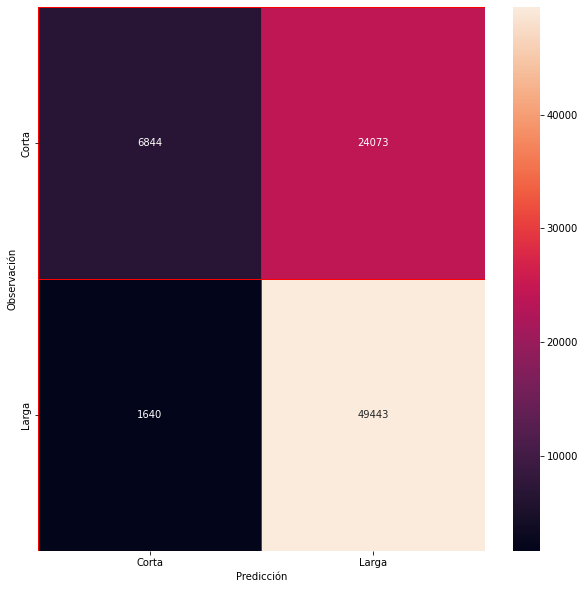

In [63]:
#Evaluación del modelo para KNN
evaluar_modelo(pipeTree ,X_train , X_test ,y_train ,y_test)

## **5) Optimización de Hiperparámetros**

* Se utiliza RandomizedSearch y luego GridSearch

## Prediccion

In [64]:
# df de datos
df_testeo = pd.read_csv('/content/hospitalizaciones_test.csv')

In [65]:
df_testeo.head()

Available Extra Rooms in Hospital          Department Ward_Facility_Code  \
0                                  3          gynecology                  F   
1                                  2  TB & Chest disease                  E   
2                                  2        radiotherapy                  E   
3                                  2          gynecology                  F   
4                                  2          anesthesia                  A   

  doctor_name  staff_available  patientid    Age  gender Type of Admission  \
0   Dr Olivia               10       2858  21-30  Female            Trauma   
1     Dr John                4      65657  51-60  Female            Trauma   
2     Dr John                7      45598  51-60   Other            Trauma   
3   Dr Olivia                1      31132  21-30  Female            Trauma   
4     Dr John                7     125021  51-60  Female            Trauma   

  Severity of Illness health_conditions  Visitors with Patient Insurance  \
0            Moderate             Other                      2        No   
1            Moderate           Asthama                      2       Yes   
2            Moderate              None                      3        No   
3            Moderate              None                      2       Yes   
4             Extreme          Diabetes                      2        No   

   Admission_Deposit  
0            4749.64  
1            4122.26  
2            5459.07  
3            3987.03  
4            4770.79

In [66]:
# Estandarización columnas
df_testeo.rename(lambda x : x.lower().strip().replace(' ','_'), axis = 1, inplace = True)

In [67]:
# Obteniendo resultados del modelo DesicionTree
pred = pipeTree.predict(df_testeo)
pred = pd.DataFrame(pred, columns=['pred'])
from google.colab import files
pred.to_csv('nicolazarte2894.csv', index = False) 
files.download('nicolazarte2894.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>